In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors
from src.signal_categories import physics_category_labels, physics_category_colors
from src.signal_categories import filetype_category_labels, filetype_category_colors


In [2]:
import umap
import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


print(f"sklearn version: {sklearn.__version__}")
print(f"umap version: {umap.__version__}")


sklearn version: 1.3.0
umap version: 0.5.4


# File Loading

In [3]:
print("loading all_df.pkl...")
with open(f"../intermediate_files/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/first_multiclass_training/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

sig_categories = topological_category_labels

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")

print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


loading all_df.pkl...
all_df.shape=(747332, 52)
loading predictions.pkl...
pred_df.shape=(71178, 22)
merging all_df and predictions.pkl...
weighting up by the fraction of test events: 0.500
merged_df.shape=(35589, 70)
presel_merged_df.shape=(24065, 70)


,run,subrun,event,filetype,wc_net_weight,topological_signal_category,physics_signal_category,wc_nue_score,wc_numu_score,wc_nc_delta_score,...,prob_2g0p,prob_2gNp1mu,prob_2g0p1mu,prob_2g_outFV,prob_1eNp,prob_1e0p,prob_0g,prob_3plusg,prob_dirt,prob_ext
0,20290,30,1510,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-15.000000,-0.445759,-3.342609,...,0.006847,0.009146,1.081974e-05,3.884699e-05,5.019382e-06,7.852225e-07,0.005227,0.001669,0.000011,0.005612
1,20290,30,1521,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-8.405992,-0.906318,-6.305526,...,0.004323,0.063918,1.342900e-05,2.552547e-05,2.232923e-05,2.734646e-06,0.002216,0.001291,0.000004,0.000742
4,20290,30,1543,nc_pi0_overlay,0.853012,2g0p,NC1pi0_0p,-9.779932,-1.000641,-7.236095,...,0.831766,0.023014,1.413385e-04,8.495483e-04,1.020405e-05,2.869084e-05,0.014845,0.002407,0.000193,0.007258
5,20290,30,1544,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-15.000000,-0.130912,1.638694,...,0.038636,0.001303,1.404332e-05,4.507262e-05,8.848031e-07,2.979955e-06,0.077666,0.005533,0.000078,0.007495
7,20672,75,3754,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-13.695713,-0.727442,-3.236898,...,0.634687,0.004054,4.241187e-05,3.152163e-04,2.066585e-05,3.048997e-05,0.000251,0.000788,0.000134,0.037318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745925,21127,121,6058,ext,15.323285,ext,ext,-15.000000,-0.032794,-3.114151,...,0.000169,0.000134,1.342654e-06,2.752117e-07,5.270298e-07,4.263510e-07,0.172643,0.000005,0.000497,0.825894
746371,20423,551,27581,ext,15.323285,ext,ext,-15.000000,-0.938013,-1.905209,...,0.013221,0.000027,2.734492e-07,1.420852e-06,4.016211e-06,2.587747e-06,0.055065,0.000005,0.906457,0.019830
746558,20194,192,9622,ext,15.323285,ext,ext,-15.000000,-3.454599,-4.554944,...,0.000866,0.000002,5.917553e-07,2.057725e-05,2.159502e-05,7.342857e-07,0.003240,0.000039,0.355974,0.636379
746934,20154,269,13456,ext,15.323285,ext,ext,-15.000000,-0.014429,-5.872269,...,0.008791,0.000075,3.397479e-05,4.497440e-07,3.394442e-06,2.769003e-06,0.069680,0.000078,0.000333,0.915805


In [4]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()

reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)

presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_13234/4263806371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


# Multi-Class Probability Visualization

In [5]:
#scaler = StandardScaler()
#probs_scaled = scaler.fit_transform(probs_2d_arr)
probs_scaled = probs_2d_arr

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

reducer.fit(probs_scaled)
embedding = reducer.transform(probs_scaled)


/opt/homebrew/Caskroom/miniconda/base/envs/base_2/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


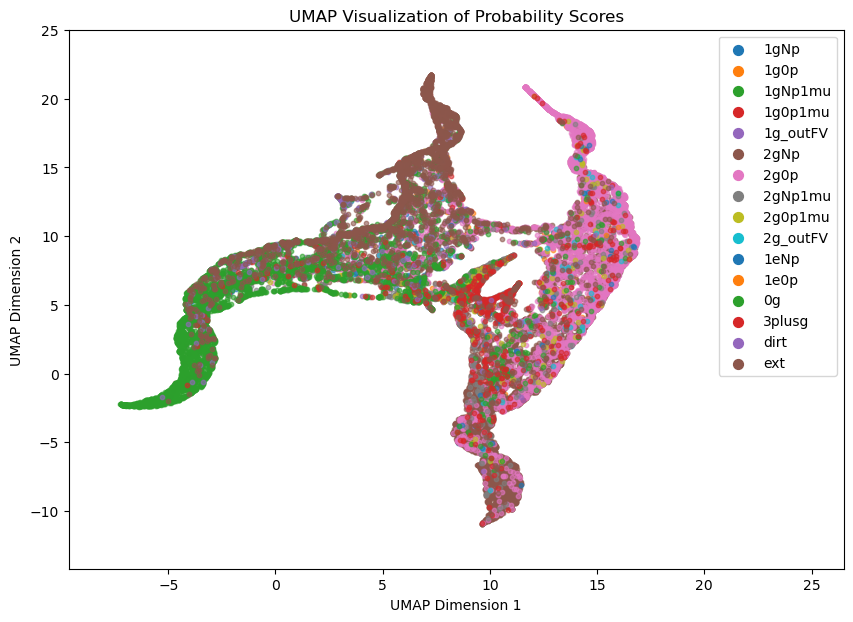

In [6]:
true_sig_categories = presel_merged_df["topological_signal_category"].to_numpy()
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(embedding[true_sig_category_mask, 0], embedding[true_sig_category_mask, 1], alpha=0.6, s=10, c=f"C{i}")
    plt.scatter([], [], s=50, c=f"C{i}", label=sig_categories[i])
plt.title('UMAP Visualization of Probability Scores')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
min_x, max_x = embedding[:, 0].min(), embedding[:, 0].max()
min_y, max_y = embedding[:, 1].min(), embedding[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right")
plt.show()


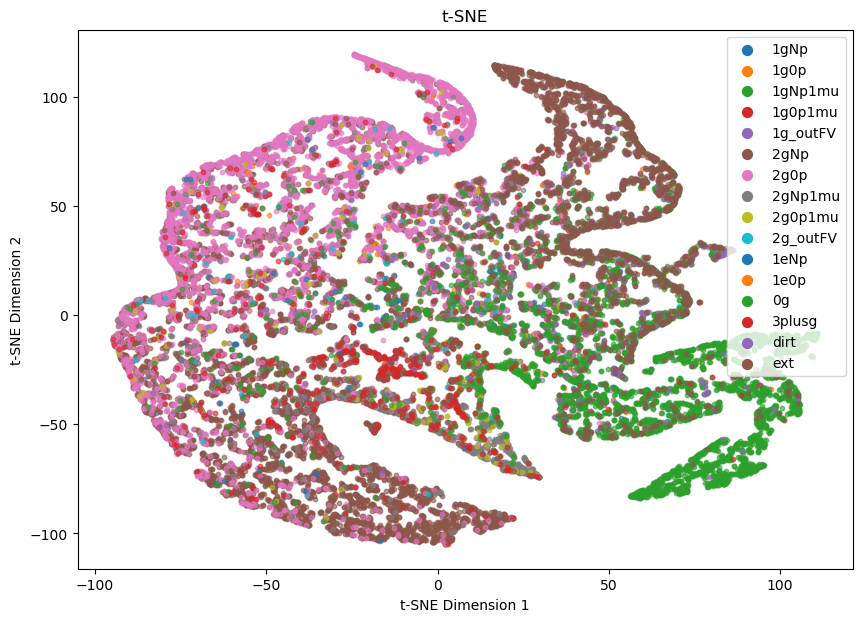

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(tsne_result[true_sig_category_mask, 0], tsne_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=f"C{i}")
    plt.scatter([], [], s=50, c=f"C{i}", label=sig_categories[i])
plt.title('t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc="upper right")
plt.show()


In [8]:
# too slow
"""
mds = MDS(n_components=2, random_state=42, normalized_stress='auto')
mds_result = mds.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(mds_result[true_sig_category_mask, 0], mds_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=f"C{i}")
    plt.scatter([], [], s=50, c=f"C{i}", label=sig_categories[i])
plt.title('MDS')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.legend(loc="upper right")
plt.show()
"""
pass

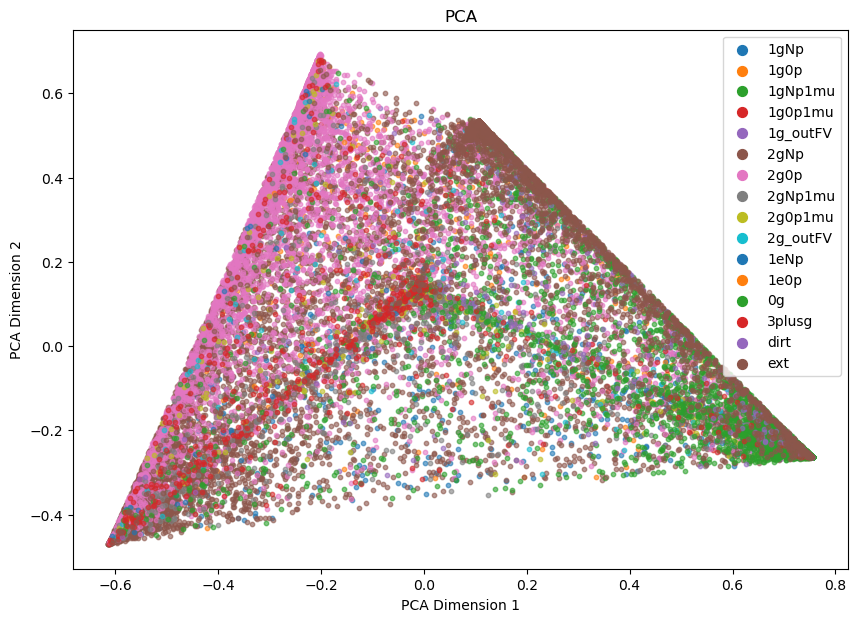

In [9]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(pca_result[true_sig_category_mask, 0], pca_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=f"C{i}")
    plt.scatter([], [], s=50, c=f"C{i}", label=sig_categories[i])
plt.title('PCA')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(loc="upper right")
plt.show()


In [10]:
# too slow
"""
isomap = Isomap(n_components=2, n_neighbors=10)
isomap_result = isomap.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(isomap_result[true_sig_category_mask, 0], isomap_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=f"C{i}")
    plt.scatter([], [], s=50, c=f"C{i}", label=sig_categories[i])
plt.title('Isomap')
plt.xlabel('Isomap Dimension 1')
plt.ylabel('Isomap Dimension 2')
plt.legend(loc="upper right")
plt.show()
"""
pass

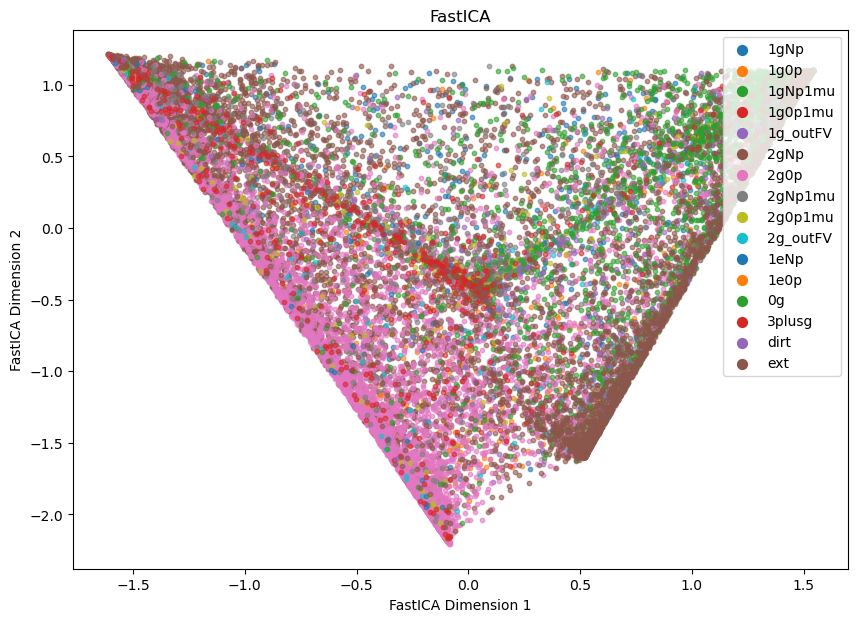

In [11]:
fastica = FastICA(n_components=2, random_state=42)
fastica_result = fastica.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(fastica_result[true_sig_category_mask, 0], fastica_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=f"C{i}")
    plt.scatter([], [], s=50, c=f"C{i}", label=sig_categories[i])
plt.title('FastICA')
plt.xlabel('FastICA Dimension 1')
plt.ylabel('FastICA Dimension 2')
plt.legend(loc="upper right")
plt.show()


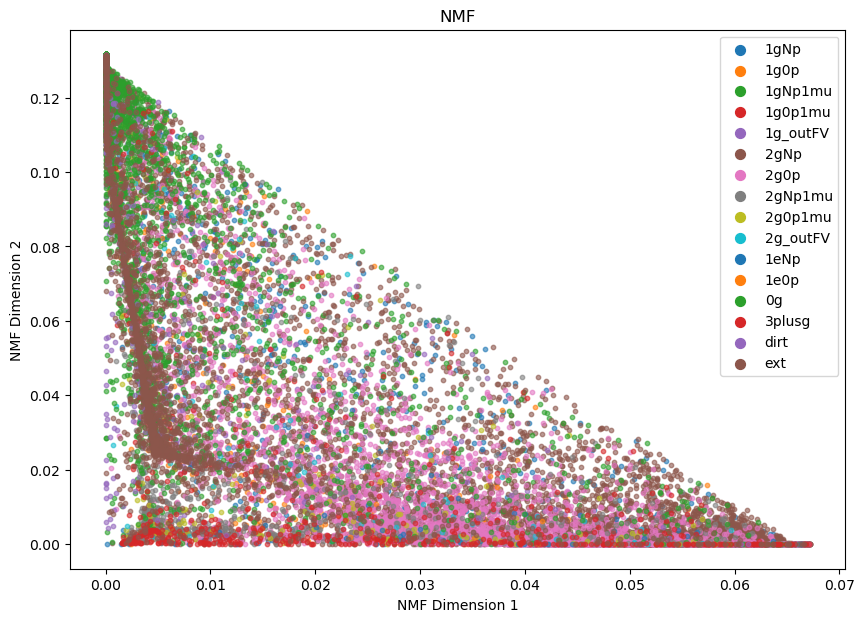

In [12]:
nmf = NMF(n_components=2, random_state=42)
nmf_result = nmf.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(nmf_result[true_sig_category_mask, 0], nmf_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=f"C{i}")
    plt.scatter([], [], s=50, c=f"C{i}", label=sig_categories[i])
plt.title('NMF')
plt.xlabel('NMF Dimension 1')
plt.ylabel('NMF Dimension 2')
plt.legend(loc="upper right")
plt.show()
